# Environmental setup

In [1]:
# %load ~/python/my_import.py
# BASIC
import numpy as np
import xarray as xr
import pandas as pd

#xr.set_options(display_style="text") # make it look better when posted online. Comment to get nicer representation of xarrays
import os
os.environ['HDF5_PLUGIN_PATH'] = '/work/bm0021/conda-envs/eerie_io/lib/python3.11/site-packages/hdf5plugin/plugins'

# matplotlib
import matplotlib
#%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.tri as mtri
import matplotlib.dates as md
import matplotlib.patches as patches
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from matplotlib import ticker
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['axes.linewidth'] = 1.5

## color
from matplotlib import cm
import cmocean
import seaborn as sns

## cartopy
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point


# scipy
from scipy import stats
from scipy import optimize
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
from scipy.stats import binned_statistic
import scipy.spatial.qhull as qhull


# metpy
import metpy
import metpy.calc as mpcalc


# etc
import subprocess
import time
import datetime
from datetime import timedelta
import calendar


# Dask
import dask # Distributed data libary
from dask import delayed
from dask import compute
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
from dask.utils import format_bytes
from distributed import Client, progress # Libaray to orchestrate distributed resources
from dask.distributed import Client
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

from pathlib import Path
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
import warnings
warnings.filterwarnings(action='ignore')

from matplotlib.dates import DateFormatter

In [2]:
def cut_region(model_lon, model_lat, elements, box):
    """
    Return mesh elements (triangles) and their indices corresponding to a bounding box.
    Parameters
    ----------
    model_lon : 1d numpy array
        longitudes of mesh vertices
    model_lat : 1d numpy array
        latitudes of mesh vertices
    box : list
        Coordinates of the box in [-180 180 -90 90] format.
    Returns
    -------
    elem_no_nan : array
        elements that belong to the region defined by the `box`.
    no_nan_triangles: array
        boolean array of element size with True for elements
        that belong to the `box`.
    """
    left, right, down, up = box

    selection = (
        (model_lon >= left)
        & (model_lon <= right)
        & (model_lat >= down)
        & (model_lat <= up)
    )

    elem_selection = selection[elements]

    no_nan_triangles = np.all(elem_selection, axis=1)

    elem_no_nan = elements[no_nan_triangles]

    return elem_no_nan, no_nan_triangles

def get_no_cyclic(model_lon, model_lat, elem_no_nan):
    """Compute non cyclic elements of the mesh."""
    d = model_lon[elem_no_nan].max(axis=1) - model_lon[elem_no_nan].min(axis=1)
    no_cyclic_elem = np.argwhere(d < 100)
    return no_cyclic_elem.ravel()


# Read data

In [3]:
dpath = '/work/mh0731/m300793/data/landuse/'

high_pft = xr.open_mfdataset(f'{dpath}/ESA_CCI_global_11PFTs.nc')
high_pft

<xarray.Dataset>
Dimensions:      (lat: 64800, lon: 129600, bounds: 2, time: 1)
Coordinates:
  * lat          (lat) float64 90.0 90.0 89.99 89.99 ... -89.99 -90.0 -90.0
  * lon          (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time         (time) datetime64[ns] 2015-01-01
Dimensions without coordinates: bounds
Data variables: (12/14)
    lat_bounds   (lat, bounds) float64 dask.array<chunksize=(64800, 2), meta=np.ndarray>
    lon_bounds   (lon, bounds) float64 dask.array<chunksize=(129600, 2), meta=np.ndarray>
    time_bounds  (time, bounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    fract_pft01  (lat, lon) float64 dask.array<chunksize=(64800, 129600), meta=np.ndarray>
    fract_pft02  (lat, lon) float64 dask.array<chunksize=(64800, 129600), meta=np.ndarray>
    fract_pft03  (lat, lon) float64 dask.array<chunksize=(64800, 129600), meta=np.ndarray>
    ...           ...
    fract_pft06  (lat, lon) float64 dask.array<chunksize=(64800, 129600), meta=np.ndarray>
    fract_pft07  (lat, lon) float64 dask.array<chunksize=(64800, 129600), meta=np.ndarray>
    fract_pft08  (lat, lon) float64 dask.array<chunksize=(64800, 129600), meta=np.ndarray>
    fract_pft09  (lat, lon) float64 dask.array<chunksize=(64800, 129600), meta=np.ndarray>
    fract_pft10  (lat, lon) float64 dask.array<chunksize=(64800, 129600), meta=np.ndarray>
    fract_pft11  (lat, lon) float64 dask.array<chunksize=(64800, 129600), meta=np.ndarray>
Attributes: (12/38)
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7cds
    title:                      Land Cover Map of ESA CCI brokered by CDS
    summary:                    This dataset characterizes the land cover of ...
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-landcover-cci.org/
    ...                         ...
    geospatial_lon_max:         180
    spatial_resolution:         300m
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778

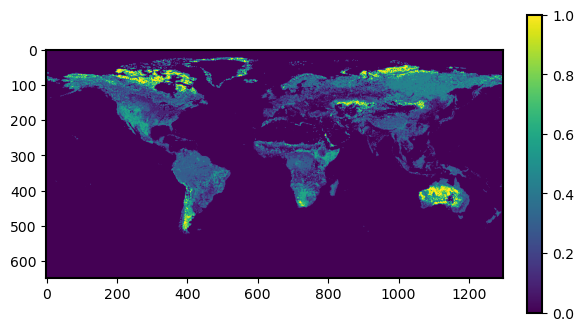

In [5]:
plot_dat = high_pft['fract_pft07'].values
img = plt.imshow(plot_dat[::100,::100])
cbar = plt.colorbar(img, orientation='vertical', fraction=0.03, pad=0.05)

# Coarsen PFTs

In [4]:
coarse_pft = high_pft.coarsen(lat=8, lon=8).reduce(np.mean)
coarse_pft

<xarray.Dataset>
Dimensions:      (lat: 8100, bounds: 2, lon: 16200, time: 1)
Coordinates:
  * lat          (lat) float64 89.99 89.97 89.94 89.92 ... -89.94 -89.97 -89.99
  * lon          (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 180.0 180.0
  * time         (time) datetime64[ns] 2015-01-01
Dimensions without coordinates: bounds
Data variables: (12/14)
    lat_bounds   (lat, bounds) float64 dask.array<chunksize=(8100, 2), meta=np.ndarray>
    lon_bounds   (lon, bounds) float64 dask.array<chunksize=(16200, 2), meta=np.ndarray>
    time_bounds  (time, bounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    fract_pft01  (lat, lon) float64 dask.array<chunksize=(8100, 16200), meta=np.ndarray>
    fract_pft02  (lat, lon) float64 dask.array<chunksize=(8100, 16200), meta=np.ndarray>
    fract_pft03  (lat, lon) float64 dask.array<chunksize=(8100, 16200), meta=np.ndarray>
    ...           ...
    fract_pft06  (lat, lon) float64 dask.array<chunksize=(8100, 16200), meta=np.ndarray>
    fract_pft07  (lat, lon) float64 dask.array<chunksize=(8100, 16200), meta=np.ndarray>
    fract_pft08  (lat, lon) float64 dask.array<chunksize=(8100, 16200), meta=np.ndarray>
    fract_pft09  (lat, lon) float64 dask.array<chunksize=(8100, 16200), meta=np.ndarray>
    fract_pft10  (lat, lon) float64 dask.array<chunksize=(8100, 16200), meta=np.ndarray>
    fract_pft11  (lat, lon) float64 dask.array<chunksize=(8100, 16200), meta=np.ndarray>
Attributes: (12/38)
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7cds
    title:                      Land Cover Map of ESA CCI brokered by CDS
    summary:                    This dataset characterizes the land cover of ...
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-landcover-cci.org/
    ...                         ...
    geospatial_lon_max:         180
    spatial_resolution:         300m
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778

In [5]:
coarse_pft = coarse_pft.compute()

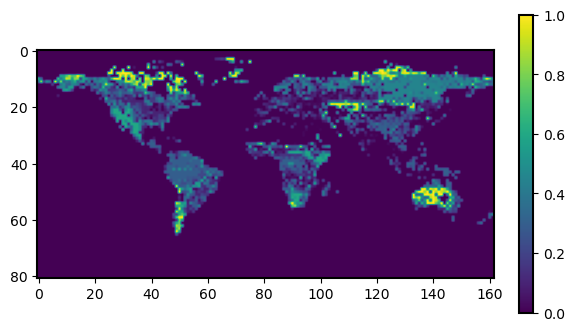

In [8]:
plot_dat = coarse_pft['fract_pft07'].values
img = plt.imshow(plot_dat[::100,::100])
cbar = plt.colorbar(img, orientation='vertical', fraction=0.03, pad=0.05)

# Write

In [7]:
dpath_out = dpath
coarse_pft.to_netcdf(f'{dpath_out}/ESA_CCI_global_11PFTs_8.nc', mode='w')

In [ ]:
# remap ESA CCI PFTs into R2B9
!cdo -P 8 -f nc4c -z zip remapycon,/work/mh0731/m300793/Carbon/grid-generator/grids/icon_grid_0015_R02B09_G.nc \
/work/mh0731/m300793/data/landuse/ESA_CCI_global_11PFTs_8.nc \
/work/mh0731/m300793/data/landuse/test_remapycon_8.nc

# Cut ESA CCI PFTs in R2B9 into EU domain
!cdo -P 8 remapnn,/work/mh0731/m300793/Carbon/grid-generator/grids/icon_grid_0015_R02B09_EU.nc \
/work/mh0731/m300793/data/landuse/test_remapycon_8.nc \
/work/mh0731/m300793/data/landuse/ESA_CCI_11PFTs_8_EU.nc

In [2]:
# Cut ESA CCI PFTs in R2B9 into germany2 domain
!cdo -P 8 remapnn,/work/mh0731/m300793/Carbon/grid-generator/grids/icon_grid_0015_R02B09_germany2.nc \
/work/mh0731/m300793/data/landuse/test_remapycon_8.nc \
/work/mh0731/m300793/data/landuse/ESA_CCI_11PFTs_8_germany2.nc


cdo    remapnn: Nearest neighbor weights from unstructured (20971520) to unstructured (3040) grid
cdo    remapnn:      8 8 8 9 9 9 9 9 9 9 9 9 910cdo    remapnn: Processed 230686720 values from 11 variables over 1 timestep [13.61s 2744MB].


# Test plot

In [11]:
dpath = '/work/mh0731/m300793/data/landuse/'

remap_pft = xr.open_mfdataset(f'{dpath}/test_remapycon_8.nc')
remap_pft

<xarray.Dataset>
Dimensions:      (cell: 20971520, nv: 3)
Coordinates:
    clon         (cell) float64 dask.array<chunksize=(20971520,), meta=np.ndarray>
    clat         (cell) float64 dask.array<chunksize=(20971520,), meta=np.ndarray>
Dimensions without coordinates: cell, nv
Data variables: (12/13)
    clon_bnds    (cell, nv) float64 dask.array<chunksize=(20971520, 3), meta=np.ndarray>
    clat_bnds    (cell, nv) float64 dask.array<chunksize=(20971520, 3), meta=np.ndarray>
    fract_pft01  (cell) float64 dask.array<chunksize=(20971520,), meta=np.ndarray>
    fract_pft02  (cell) float64 dask.array<chunksize=(20971520,), meta=np.ndarray>
    fract_pft03  (cell) float64 dask.array<chunksize=(20971520,), meta=np.ndarray>
    fract_pft04  (cell) float64 dask.array<chunksize=(20971520,), meta=np.ndarray>
    ...           ...
    fract_pft06  (cell) float64 dask.array<chunksize=(20971520,), meta=np.ndarray>
    fract_pft07  (cell) float64 dask.array<chunksize=(20971520,), meta=np.ndarray>
    fract_pft08  (cell) float64 dask.array<chunksize=(20971520,), meta=np.ndarray>
    fract_pft09  (cell) float64 dask.array<chunksize=(20971520,), meta=np.ndarray>
    fract_pft10  (cell) float64 dask.array<chunksize=(20971520,), meta=np.ndarray>
    fract_pft11  (cell) float64 dask.array<chunksize=(20971520,), meta=np.ndarray>
Attributes: (12/44)
    CDI:                        Climate Data Interface version 2.2.4 (https:/...
    Conventions:                CF-1.6
    number_of_grid_used:        15
    grid_file_uri:              http://icon-downloads.mpimet.mpg.de/grids/pub...
    uuidOfHGrid:                0f1e7d66-637e-11e8-913b-51232bb4d8f9
    source:                     MERIS FR L1B version 5.05, MERIS RR L1B versi...
    ...                         ...
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778
    CDO:                        Climate Data Operators version 2.2.2 (https:/...
    cdo_openmp_thread_number:   8

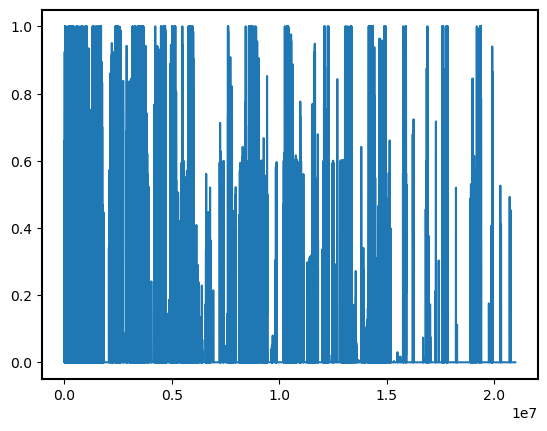

In [12]:
plt.plot(remap_pft['fract_pft07'].values)

In [13]:
plot_dat = remap_pft['fract_pft07'].values
# plt.plot(plot_dat)
img = plt.scatter(remap_pft.clon[::64], remap_pft.clat[::64], plot_dat[::64])
cbar = plt.colorbar(img, orientation='vertical', fraction=0.03, pad=0.05)


In [14]:
dpath = '/work/mh0731/m300793/data/landuse/'

EU_pft = xr.open_mfdataset(f'{dpath}/ESA_CCI_11PFTs_8_EU.nc')
EU_pft

<xarray.Dataset>
Dimensions:      (cell: 279900, nv: 3)
Coordinates:
    clon         (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    clat         (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
Dimensions without coordinates: cell, nv
Data variables: (12/13)
    clon_bnds    (cell, nv) float64 dask.array<chunksize=(279900, 3), meta=np.ndarray>
    clat_bnds    (cell, nv) float64 dask.array<chunksize=(279900, 3), meta=np.ndarray>
    fract_pft01  (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    fract_pft02  (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    fract_pft03  (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    fract_pft04  (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    ...           ...
    fract_pft06  (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    fract_pft07  (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    fract_pft08  (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    fract_pft09  (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    fract_pft10  (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    fract_pft11  (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
Attributes: (12/42)
    CDI:                        Climate Data Interface version 2.2.4 (https:/...
    Conventions:                CF-1.6
    uuidOfHGrid:                b1106b54-c45b-11ee-8367-4fb6911d3de6
    source:                     MERIS FR L1B version 5.05, MERIS RR L1B versi...
    institution:                UCLouvain
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7cds
    ...                         ...
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778
    cdo_openmp_thread_number:   8
    CDO:                        Climate Data Operators version 2.2.2 (https:/...

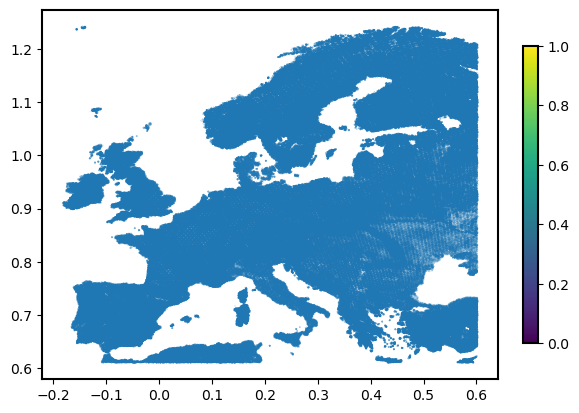

In [16]:
plot_dat = EU_pft['fract_pft07'].values
# plt.plot(plot_dat)
img = plt.scatter(EU_pft.clon[::2], EU_pft.clat[::2], plot_dat[::2])
cbar = plt.colorbar(img, orientation='vertical', fraction=0.03, pad=0.05)